# 2017 Data Integration Analysis

This notebooke contains a rough approach to data integration for the first year of Aim 1 of the NSF/PGRP project "Adapting Perennial Crops for Climate Change: Graft Transmissible Effects of Rootstocks on Grapevine Shoots" (1546869). The manuscript(s) associated with the data can be found in the README of this GitHIb repository.

This code is provided for reproducability and as a backbone for future integration analysis.

Questions about this code and project can be directed to Zachary N. Harris or Allison J. Miller.

To Self: Personal laptop needs env R_test for shapes package

To others: install RGL before irkernel

In [1]:
library('tidyverse')
library('shapes')
library('viridis')
library('corrplot')
library('igraph')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: viridisLite
corrplot 0.84 loaded

Attaching package: ‘igraph’

The following object is masked from ‘package:shapes’:

    V

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



## Controlling Sample Names

In order for any of this to work, we need a set of sample names that will be consistent across all data types. Here, I am going to use the convention of the RNAseq sample names because they are shorter. Anyone who reads this should appreciate the fuck out of this because it took forever. 

This is adapted from Jason Londo's file called "Project tracking metadata.gsheet". Notice the refactoring. Notice the reformating. WOW.

Now as this script goes, I will be renaming the columns of each data set with these RNAseq-inspired names. They will be the rownames for each pca.x dataframe. 

In [2]:
master_meta <- read.csv('Project_tracking_metadata.csv')

master_meta <- master_meta %>% select(COLLECTED_DATE, YEAR, ROW:TISSUE, ROOTSTOCK:TREATMENT, SEQUENCE_NAME)

master_meta <- master_meta[master_meta$YEAR == 2017,]
master_meta <- master_meta[master_meta$TISSUE == 'LEAF',]
master_meta$Phenology <- factor(master_meta$COLLECTED_DATE, levels=c('22/05/17', '30/07/17', '25/09/17'), labels=c('Anthesis','Veraison','Harvest'))
master_meta$indexer <- paste(master_meta$Phenology, master_meta$ROW, master_meta$BLOCK, master_meta$VINE, sep='_')
master_meta$Rootstock <- factor(master_meta$ROOTSTOCK, levels=c('OWN', '1103PAULSEN', '3309C', 'SO4'), labels=c('Ungrafted', '1103P', '3309C', 'SO4'))
master_meta$Irrigation <- factor(master_meta$TREATMENT, levels=c('NONE', 'RDI', 'FULL'), labels=c('None', 'RDI', 'Full'))
master_meta$Row <- master_meta$ROW

master_meta <- master_meta %>% select(SEQUENCE_NAME:Row)
master_meta <- head(master_meta, 217)

#sample 4_L is from vine 2, but it was sequenced in place of vine 3. I'm changing the label to make it fit other data
master_meta$indexer[master_meta$SEQUENCE_NAME=='A1Y1_4_L'] <- "Anthesis_8_B_3"
master_meta <- master_meta[-5,]

#Try to make the sample name in this file look like mine without python...
# note this may show some inconsistency converting sample_name.N to the correct int
# if so, it can be coerced by `master_meta$sample_name.N <- as.numeric(as.character(master_meta$sample_name.N))`
master_meta <- transform(master_meta, sample_name=reshape::colsplit(SEQUENCE_NAME, split = "_", names = c('Y', 'N', 'T')))
master_meta$sampleName <- paste(master_meta$sample_name.Y, formatC(master_meta$sample_name.N, width=3, flag="0"), master_meta$sample_name.T, sep="_")
head(master_meta)

master_meta <- master_meta %>% select(sampleName, Phenology:Row)
colnames(master_meta) <- c('sampleName', 'Phenology.m', 'indexer', 'Rootstock.m', 'Irrigation.m', 'Row.m')

head(master_meta)

write.csv(master_meta, file='2017_master_key_integration.csv')

,SEQUENCE_NAME,Phenology,indexer,Rootstock,Irrigation,Row,sample_name.Y,sample_name.N,sample_name.T,sampleName
1,A1Y1_1_L,Anthesis,Anthesis_8_A_2,1103P,None,8,A1Y1,1,L,A1Y1_001_L
2,A1Y1_2_L,Anthesis,Anthesis_8_A_3,1103P,None,8,A1Y1,2,L,A1Y1_002_L
3,A1Y1_3_L,Anthesis,Anthesis_8_B_2,3309C,None,8,A1Y1,3,L,A1Y1_003_L
4,A1Y1_4_L,Anthesis,Anthesis_8_B_3,3309C,None,8,A1Y1,4,L,A1Y1_004_L
6,A1Y1_5_L,Anthesis,Anthesis_8_C_2,SO4,None,8,A1Y1,5,L,A1Y1_005_L
7,A1Y1_6_L,Anthesis,Anthesis_8_C_3,SO4,None,8,A1Y1,6,L,A1Y1_006_L


## Ionomics

In this section, we deal with the processing of the ionomics data. First, we will process the data in the same way as the ionomics standalone script. Second, we will extract out the youngest leaf for 72 plants measured for all traits. Finally, we will ensure that the data are factored using a controlled vocabulary. 

These data will be used as the basis for a principal components analysis to capture the primary axes of variation in those ion profiles. 

#### Clean the Data like the Primary Analysis

In [3]:
idf <- read.csv('~/Documents/MtVernon/2019/ionomics/2017_ionomics_juliaFixed.csv')
idf$irrigation <- idf$treatment
head(idf)

'%!in%' <- Negate('%in%')
idf$newSampleName <- paste(idf$sample, idf$time_point, sep='_')
to_filter <- rownames(table(idf$newSampleName)[table(idf$newSampleName) == 2])
idf <- idf[idf$newSampleName %!in% to_filter, ]

table(idf$block)
table(idf$rootstock)
table(idf$irrigation)
table(idf$leafpos)
table(idf$row)
table(idf$phenology)

X,samplename,year,phenology,row,replicate,cell,leafpos,treatment,block,⋯,Ni,Cu,Zn,As,Se,Rb,Sr,Mo,Cd,irrigation
1,2017_anthesis_8_E_1_Y,2017,Anthesis,8,1,E,Y,None,4,⋯,0.77143369,10.747744,19.30181,0.01133777,0.009937403,11.522449,9.661253,0.08400322,0.024697238,None
2,2017_harvest_11_B_2_Y,2017,Harvest,11,2,B,Y,RDI,2,⋯,0.03997534,5.113214,17.17969,0.01200985,0.013811064,6.246615,20.044803,0.15022273,0.025295544,RDI
3,2017_veraison_14_B_2_Y,2017,Veraison,14,2,B,Y,RDI,3,⋯,1.57125600,5.315436,11.95915,0.02407721,0.022184104,4.463661,66.194720,0.17901887,0.003469065,RDI
7,2017_anthesis_10_F_4_Z,2017,Anthesis,10,4,F,Z,Full,4,⋯,1.06607950,5.224421,29.91493,0.02381154,0.044536917,3.612188,82.737953,0.27983246,0.027167219,Full
8,2017_harvest_14_E_1_X,2017,Harvest,14,1,E,X,RDI,6,⋯,0.04640472,35.052891,17.73761,0.01355793,0.013667908,6.966490,35.942172,0.17696249,0.038010029,RDI
9,2017_veraison_10_B_1_Z,2017,Veraison,10,1,B,Z,Full,1,⋯,1.28312238,5.454629,15.85992,0.02798158,0.056292285,4.478028,50.201681,0.31560113,0.016191926,Full



  1   2   3   4   5   6 
424 428 426 429 429 429 


   1103P    3309C      SO4 Ugrafted 
     641      642      641      641 


Full None  RDI 
 850  855  860 


  X   Y   Z 
859 852 854 


  8   9  10  11  12  13  14  15  16 
284 287 282 288 285 284 285 287 283 


Anthesis  Harvest Veraison 
     853      862      850 

#### Extract the Youngest Leaves from the Common 72 Vines

In [4]:
idf <- idf[idf$leafpos == 'X',]
idf <- idf[idf$block %in% c(1,2,3),]
idf <- idf[idf$replicate == 2 | idf$replicate == 3,]
dim(idf)

[1] 212  33

#### Factor to Controlled Vocabulary

In [5]:
idf$Block <- factor(idf$block, levels=c('1', '2', '3'), labels=c('A', 'B', 'C'))
idf$Rootstock <- factor(idf$rootstock, levels=c('Ugrafted', '1103P', '3309C', 'SO4'), labels=c('Ungrafted', '1103P', '3309C', 'SO4'))
idf$Irrigation <- factor(idf$irrigation, levels=c('None', 'RDI', 'Full'))
idf$Phenology <- factor(idf$phenology, levels=c('Anthesis', 'Veraison', 'Harvest'))
idf$indexer <- paste(idf$Phenology, idf$row, idf$cell, idf$replicate, sep='_')

idf <- select(idf, B:Cd, Block:Phenology, indexer)

#### Fit PCA

In [9]:
## sanity check  - should print 212 3 times
test.labels <- merge(master_meta, idf, on='indexer')
sum(test.labels$Phenology.m == test.labels$Phenology)
sum(test.labels$Rootstock.m == test.labels$Rootstock)
sum(test.labels$Irrigation.m == test.labels$Irrigation)

ipca <- select(test.labels, B:Cd)
rownames(ipca) <- test.labels$sampleName

write.csv(ipca, file='2017_ionomics_integration.csv')

[1] 212

[1] 212

[1] 212

In [46]:
head(ipca)

,B,Na,Mg,Al,P,S,K,Ca,Fe,Mn,Co,Ni,Cu,Zn,As,Se,Rb,Sr,Mo,Cd
A1Y1_017_L,43.88419,93.33059,2214.140,28.26122,5716.630,1753.906,15313.96,11580.853,86.35039,66.96620,0.2093123,1.1346541,18.76177,59.57823,0.037056978,0.00000000,31.55919,13.085851,0.3898808,0.10151032
A1Y1_018_L,36.77627,59.67146,2435.340,19.32759,5911.446,1784.504,14779.93,12724.465,78.47190,68.38584,0.2301409,1.1823310,18.02814,52.90440,0.016088652,0.00000000,24.05974,17.475250,0.2482742,0.06345002
A1Y1_019_L,14.67495,18.79769,1698.259,12.33256,4757.657,1531.452,16191.23,5470.320,63.93061,34.81513,0.3293212,0.2835574,12.95159,30.60075,0.008100901,0.02886441,19.51610,5.841769,1.2160976,0.05087582
A1Y1_020_L,31.27977,63.50775,2460.307,26.85297,6726.201,1980.587,17276.29,17259.244,95.41273,66.89999,0.1720622,0.9011042,15.67393,44.63793,0.017294938,0.00000000,19.10180,29.833563,0.2259464,0.05855009
A1Y1_021_L,29.47948,75.01673,1872.218,22.46259,5041.204,1797.604,14001.14,8783.552,78.73555,60.13249,0.1321290,0.8209164,11.07159,35.81637,0.014498238,0.05887104,16.36014,19.851069,0.1272748,0.06885189
A1Y1_022_L,32.39730,43.70503,2271.361,26.99522,6817.378,1569.770,15405.18,11716.613,87.77674,67.53898,0.1761201,0.8857374,14.03350,40.36461,0.016940270,0.01560662,18.51476,27.474170,0.1553324,0.02412402


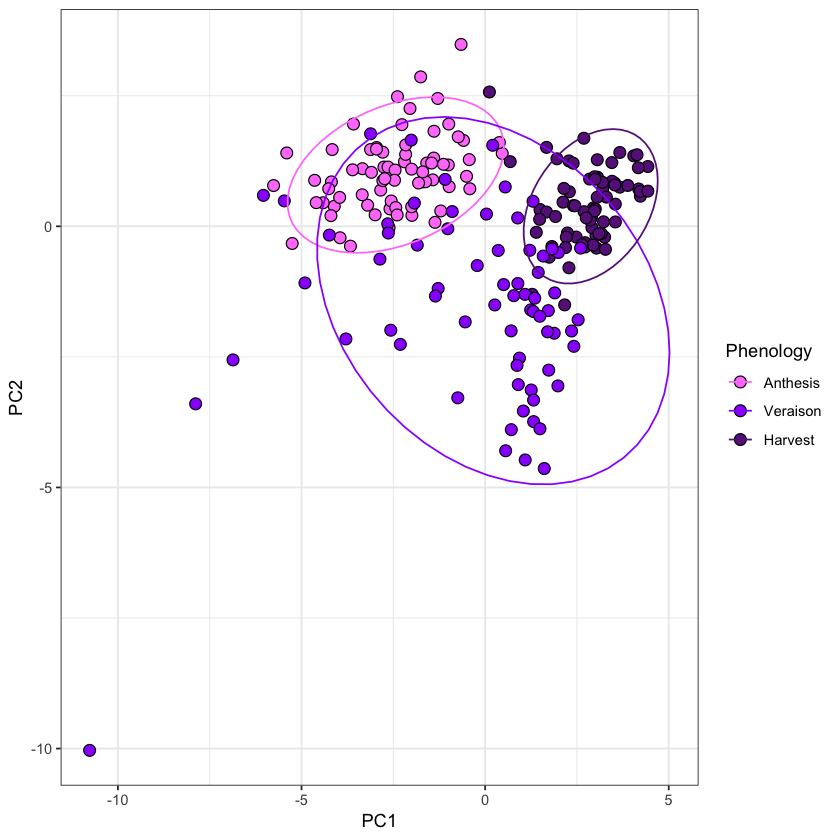

In [10]:
ipca <- prcomp(ipca, scale=T, center=T)
ipca.x <- as.data.frame(ipca$x)

## check
ggplot(ipca.x, aes(x=PC1, y=PC2, fill=test.labels$Phenology, shape=test.labels$Phenology)) + 
  geom_point(size = 3) + 
  scale_shape_manual('Phenology', values=c(21, 21, 21)) + 
  scale_fill_manual('Phenology', values=c('orchid1', 'purple1', 'darkorchid4')) + 
  stat_ellipse(aes(color=test.labels$Phenology)) + scale_color_manual('Phenology', values=c('orchid1', 'purple1', 'darkorchid4')) + 
  theme_bw()

## Metabolomics

This section will prepare the metabolomics data in a manner similar to ionomics. First, I will process the data similar to the standalone metabolomics script. Second, I will ensure that the factors are aligned with the controlled vocab of the ionomics data. Finally, I will fit a PCA to those data. 

*Note*: There are only data from Veraison and Harvest. This will have to be acknowledged in the integration. 

### Clean Data as Primary Analsysis

In [11]:
mdf <- read.csv('../metabolomics/2017_leafMetabolomics_sigFeatures_MK.csv')
mdf <- mdf[mdf$rootstock != 'so4-rootstock',]
mdf <- mdf[mdf$year == 2017,]

block_A <- c('8a', '8b', '8c', '8d', '9a', '9b', '9c', '9d', '10a', '10b', '10c', '10d')
block_B <- c('11a', '11b', '11c', '11d', '12a', '12b', '12c', '12d', '13a', '13b', '13c', '13d')
block_C <- c('14a', '14b', '14c', '14d', '15a', '15b', '15c', '15d', '16a', '16b', '16c', '16d')

new_col <- data.frame(id=paste(mdf$row, mdf$block, sep=''), block=rep(NA, length(mdf$row)))
new_col$block <- ifelse(new_col$id %in% block_A, 'A',
                       ifelse(new_col$id %in% block_B, 'B',
                             ifelse(new_col$id %in% block_C, 'C', NA)))

mdf$Block <- new_col$block

table(mdf$Block)
table(mdf$rootstock)
table(mdf$irrigation)
table(mdf$row)
table(mdf$phenology)


 A  B  C 
42 45 45 


        1103P         3309C           own           so4 so4-rootstock 
           32            34            34            32             0 


Full None  RDI 
  45   44   43 


 8  9 10 11 12 13 14 15 16 
15 13 14 15 16 14 15 15 15 


 harvest Veraison 
      66       66 

#### Factor to Controlled Vocabulary

In [12]:
mdf$Rootstock <- factor(mdf$rootstock, levels=c('own', '1103P', '3309C', 'so4'), labels=c('Ungrafted', '1103P', '3309C', 'SO4'))
mdf$Irrigation <- factor(mdf$irrigation, levels=c('None', 'RDI', 'Full'))
mdf$Phenology <- factor(mdf$phenology, levels=c('Veraison', 'harvest'), labels=c('Veraison', 'Harvest'))

#### PCA

In [13]:
mdf$block <- factor(mdf$block, levels=c('a', 'b', 'c', 'd'), labels=c('A', 'B', 'C', 'D'))
mdf$indexer <- paste(mdf$Phenology, mdf$row, mdf$block, mdf$replicate, sep='_')

master_meta.copy <- master_meta[master_meta$Phenology != 'Anthesis',]
master_meta.copy$Phenology.m <- factor(master_meta.copy$Phenology.m, levels=c('Veraison' ,'Harvest'))

## sanity check  - should print 132 3 times
test.labels <- merge(master_meta.copy, mdf, on='indexer')
test.labels$Phenology <- factor(test.labels$Phenology, levels=c('Veraison' ,'Harvest'))

sum(test.labels$Phenology.m == test.labels$Phenology)
sum(test.labels$Rootstock.m == test.labels$Rootstock)
sum(test.labels$Irrigation.m == test.labels$Irrigation)

mpca <- select(test.labels, X1:X661)
rownames(mpca) <- test.labels$sampleName

write.csv(mpca, file='2017_metabolomics_integration.csv')

[1] 132

[1] 132

[1] 132

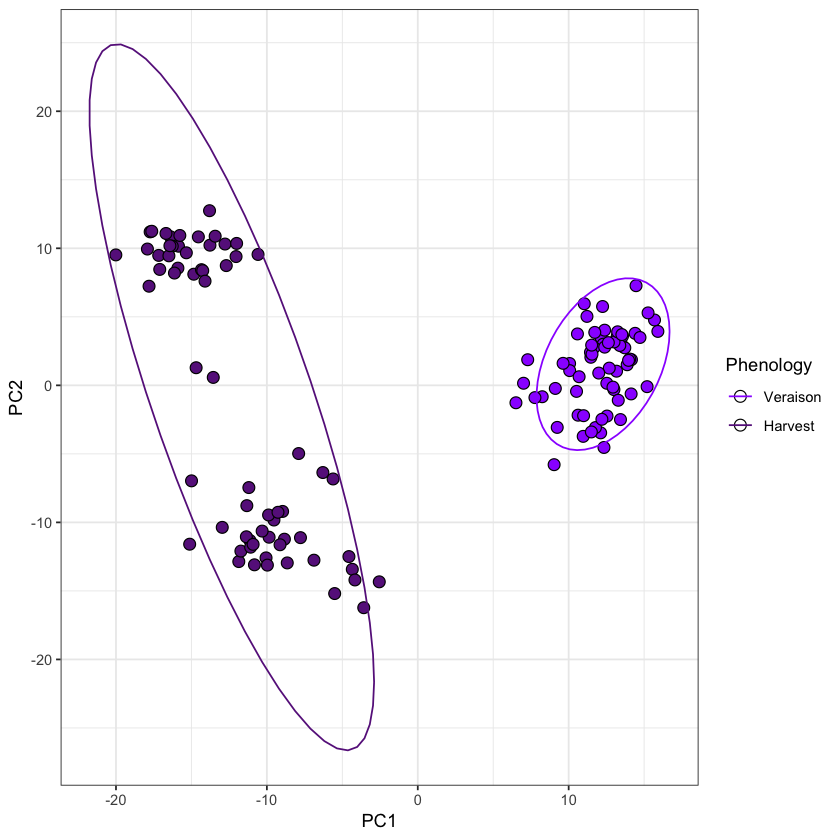

In [14]:
mpca <- prcomp(mpca, center=T, scale=T)
mpca.x <- as.data.frame(mpca$x)

## check
ggplot(mpca.x, aes(x=PC1,y=PC2, fill=mdf$Phenology, shape=mdf$Phenology)) + 
  geom_point(size = 3) + 
  scale_shape_manual('Phenology', values=c(21, 21)) + 
  scale_fill_manual('Phenology', values=c('purple1', 'darkorchid4')) + 
  stat_ellipse(aes(color=mdf$Phenology)) + scale_color_manual('Phenology', values=c('purple1', 'darkorchid4')) + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white"))) +
  theme_bw()

## Gene Expression

This section will prepare the gene expression data in a manner similar to ionomics. First, I will process the data similar to the standalone gene expression scripts. Second, I will ensure that the factors are aligned with the controlled vocab of the ionomics data. Finally, I will fit a PCA to those data. 

Here, all of the leaf data in the vst space will be used. 

### Clean Data as Primary Analsysis

In [15]:
load('../geneExpression/2017_geneExpressionLeaf_filt_VSD.Rdata')
gdf <- t(vsd_counts)

### Factor to Controlled Vocab

In [16]:
gmeta <- read.csv('../geneExpression/2017_treatment_metadata.csv')
gmeta <- gmeta[which(gmeta$sampleName %in% rownames(gdf)),]

gmeta$Rootstock <- factor(gmeta$Rootstock, levels=c('Own', '1103P', '3309C', 'SO4'), labels=c('Ungrafted', '1103P', '3309C', 'SO4'))
gmeta$Irrigation <- factor(gmeta$Irrigation, levels=c('none', 'RDI', 'full'), labels=c('None', 'RDI', 'Full'))
gmeta$Phenology <- factor(gmeta$Phenology, levels=c('anthesis', 'veraison', 'harvest'), labels=c('Anthesis', 'Veraison', 'Harvest'))

### PCA

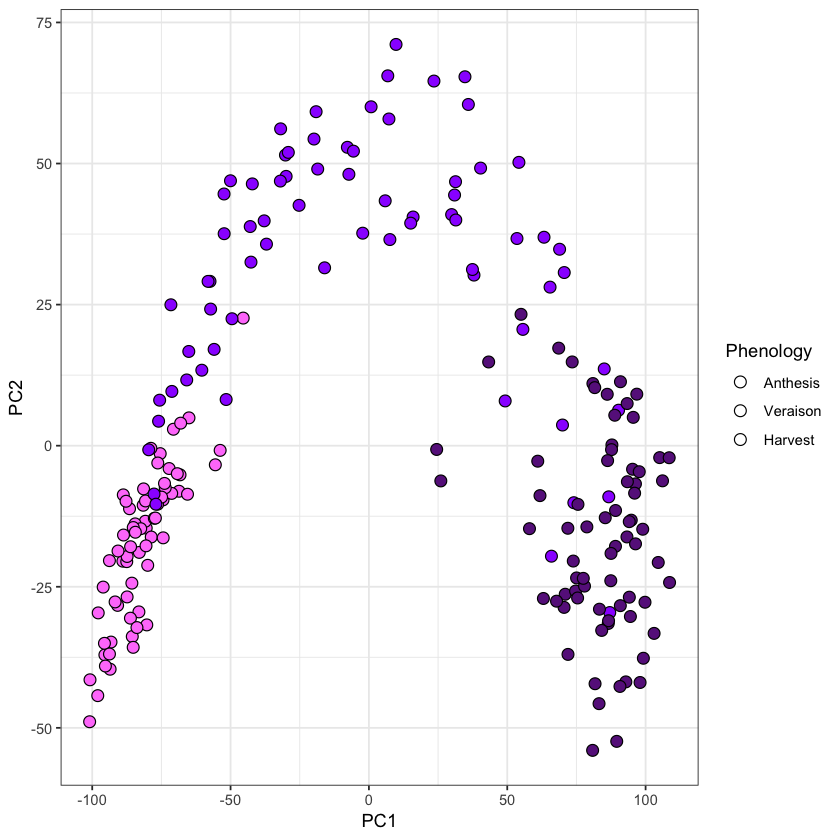

In [17]:
gpca <- prcomp(gdf)
gpca.x <- as.data.frame(gpca$x)

## check
ggplot(gpca.x, aes(x=PC1,y=PC2, fill=gmeta$Phenology, shape=gmeta$Phenology)) + 
  geom_point(size = 3) + 
  scale_shape_manual('Phenology', values=c(21, 21, 21)) + 
  scale_fill_manual('Phenology', values=c('orchid1', 'purple1', 'darkorchid4')) + 
  #stat_ellipse(aes(color=gmeta$Phenology)) + scale_color_manual('Phenology', values=c('orchid1', 'purple1', 'darkorchid4')) + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white"))) +
  theme_bw()


## Leaf Shape

Like Ionomics, take only the youngest leaves. But reprocess similary to full leaf shape analysis then fit PCA to subset.  

In [18]:
anthesis <- read.csv('../leaf_shape/2017_anthesis_reformat_subsampled_final.csv')
veraison <- read.csv('../leaf_shape/2017_veraison_reformat_subsampled_final.csv')
harvest  <- read.csv('../leaf_shape/2017_morphology_withPhenology_zh_reAnalysis_Harvest_reformat_leafRange_final.csv')
harvest$indexer <- paste(harvest$Row, harvest$Block, harvest$Rep, sep='')

anthesis$Phenology <- rep('Anthesis', dim(anthesis)[1])
veraison$Phenology <- rep('Veraison', dim(veraison)[1])
harvest$Phenology <- rep('Harvest', dim(harvest)[1])

sdf <- rbind(anthesis, veraison, harvest)

sdf <- sdf[sdf$Rep == 2 | sdf$Rep == 3,]
sdf <- sdf[sdf$Block %in% c('A', 'B', 'C', 'D'),]
sdf <- sdf[sdf$Leaf_index == 1,]

smeta <- read.csv('../leaf_shape/MtVernon_metadata.csv')
smeta$indexer <- paste(smeta$Row, smeta$Block, smeta$Rep, sep='')
smeta$Row <- NULL
smeta$Block <- NULL
smeta$Rep <- NULL
smeta$Time_block <- NULL

sdf <- merge(sdf, smeta, on='indexer', how='left')
sdf$indexer <- paste(sdf$Phenology, sdf$Row, sdf$Block, sdf$Rep, sep='_')

block_A <- c('8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '10A', '10B', '10C', '10D')
block_B <- c('11A', '11B', '11C', '11D', '12A', '12B', '12C', '12D', '13A', '13B', '13C', '13D')
block_C <- c('14A', '14B', '14C', '14D', '15A', '15B', '15C', '15D', '16A', '16B', '16C', '16D')

new_col <- data.frame(id=paste(sdf$Row, sdf$Block, sep=''), Block=rep(NA, length(sdf$Row)))
new_col$Block <- ifelse(new_col$id %in% block_A, 'A',
                       ifelse(new_col$id %in% block_B, 'B',
                             ifelse(new_col$id %in% block_C, 'C', NA)))


sdf$Block <- new_col$Block

sdf$Rootstock <- factor(sdf$Rootstock, levels=c('Own', '1103P', '3309C', 'SO4'), labels=c('Ungrafted', '1103P', '3309C', 'SO4'))
sdf$Irrigation <- factor(sdf$Irrigation, levels=c('None', 'RDI', 'Full'))
sdf$Phenology <- factor(sdf$Phenology, levels=c('Anthesis', 'Veraison', 'Harvest'))

table(sdf$Block)
table(sdf$Rootstock)
table(sdf$Irrigation)
table(sdf$Phenology)


 A  B  C 
66 68 67 


Ungrafted     1103P     3309C       SO4 
       48        52        51        50 


None  RDI Full 
  67   67   67 


Anthesis Veraison  Harvest 
      61       68       72 

#### Generalized Procrustes Analysis

In [19]:
morpho <- sdf %>% select(x1:y17)

n_landmarks <- 17
n_leaves <- dim(morpho)[1]

# Apprently we can't be elegant. Write the table, and then call read.in to read it back in. 
write.table(as.matrix(morpho), col.names=F, row.names=F, file='2017_morphology_young72.txt')
morpho_reformat_gpa <- read.in('2017_morphology_young72.txt', n_landmarks, 2)

# looks right, I guess
dim(morpho_reformat_gpa)

# fit the GPA
GPA <- procGPA(morpho_reformat_gpa, reflect=TRUE)

# forced restructring of rotated matrix
morpho_GPA_rotated_flat <- matrix(nrow=n_leaves, ncol=(n_landmarks*2))

morpho_GPA_rotated <- as.matrix(GPA$rotated)
for(j in c(1:n_leaves)) {
    # extract all coordinates from the original table as blocks of 34 (n_landmarks*2) rows,
    # each representing the x coordinates of a leaf, one by one, as calculated from j.
    sub.data <- as.matrix(morpho_GPA_rotated[ (1+34*(j-1)):((1+34*(j-1))+33), 1])
    sub.data.x <- as.matrix(sub.data[1:n_landmarks,])
    sub.data.y <- as.matrix(sub.data[(n_landmarks+1):(n_landmarks*2),])

    # dissect out each x and y coordinate of the landmark data and put it into every other 
    # column of a single row (for a single leaf) in the overall table

    for (i in 1:n_landmarks){
        morpho_GPA_rotated_flat[j,(i*2-1)] <- sub.data.x[i, 1]
        morpho_GPA_rotated_flat[j, (i*2)] <- sub.data.y[i, 1]
    }
}

colnames(morpho_GPA_rotated_flat) <- c("x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "x5", "y5", "x6", "y6", "x7", "y7", "x8", "y8", "x9", "y9", "x10", "y10", "x11", "y11", "x12", "y12", "x13", "y13", "x14", "y14", "x15", "y15", "x16", "y16", "x17", "y17")

head(morpho_GPA_rotated_flat)

[1]  17   2 201

[1] "To speed up use option distances=FALSE"
[1] "To speed up use option pcaoutput=FALSE"


x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,⋯,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17
-9.433943,137.9126,18.911049,-298.7056,-154.4530,-164.8972,137.3619,-159.4375,-211.9233,-192.3286,⋯,-15.375533,28.014454,-62.80410,66.20690,38.40105,68.28216,-66.45467,135.0281,46.55096,137.8695
7.674827,123.8073,-20.586856,-308.6189,-171.4195,-182.4548,152.7163,-183.7116,-204.4917,-204.4638,⋯,3.643758,-3.373664,-44.11850,53.01389,52.43076,74.17027,-24.20580,113.6541,45.56811,120.4594
6.926467,164.8998,32.738129,-399.2165,-121.2672,-116.6371,120.0980,-108.5088,-227.6808,-222.4141,⋯,1.246009,48.089945,-49.81817,96.52786,58.98122,99.24525,-59.66706,152.2123,75.49943,143.1606
-9.813145,122.7168,-36.868505,-332.9491,-136.2886,-149.7448,130.0208,-168.0310,-208.9857,-176.8890,⋯,-4.245515,1.903819,-60.22661,62.54139,42.55824,64.47890,-57.88817,113.0365,37.07225,122.7780
-4.670362,130.5265,8.827063,-340.9305,-155.2291,-149.2489,151.0537,-151.8951,-228.2206,-197.1416,⋯,-1.409131,24.769918,-44.66626,69.47827,61.85017,66.27697,-39.41604,125.1311,28.06058,136.3403
-12.446836,110.7317,16.051730,-383.7440,-128.6072,-111.3460,153.2474,-115.1407,-271.2552,-173.6805,⋯,9.344607,12.936638,-62.54239,52.41799,52.28366,62.91985,-64.95483,107.9494,49.87122,118.4513


,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,⋯,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17
mean_leaf,0.1421064,128.8937,1.268237,-341.3633,-132.621,-145.3308,132.7384,-148.6325,-224.5112,-206.7325,⋯,-0.6685747,18.15829,-52.41427,66.99764,50.26963,69.1129,-42.83082,123.3947,40.75337,124.9366


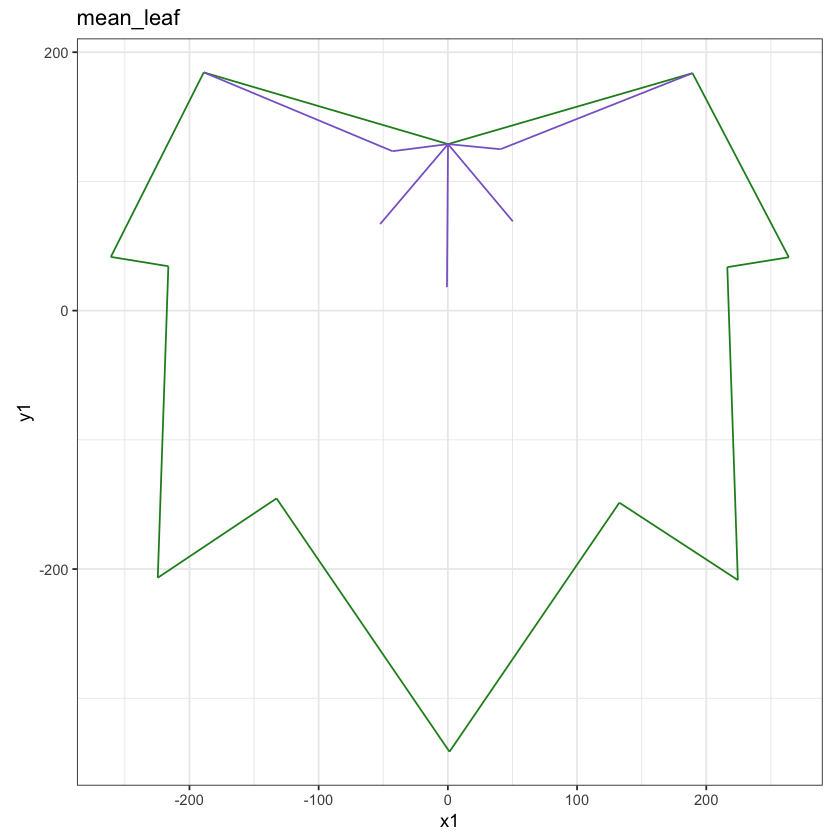

In [20]:
plot_leaf <- function(leaf, title=''){
    vein_colour <- "mediumpurple3"
    margin_colour <- "forestgreen"

    p <- ggplot(leaf, aes(x=x1, y=y1, xend=x12, yend=y12)) + 
        geom_segment(colour=margin_colour) + 
        geom_segment(aes(x=x12, y=y12, xend=x10, yend=y10), colour=margin_colour) + 
        geom_segment(aes(x=x10, y=y10, xend=x8, yend=y8), colour=margin_colour) + 
        geom_segment(aes(x=x8, y=y8, xend=x6, yend=y6), colour=margin_colour) + 
        geom_segment(aes(x=x6, y=y6, xend=x4, yend=y4), colour=margin_colour) + 
        geom_segment(aes(x=x4, y=y4, xend=x2, yend=y2), colour=margin_colour) + 
        geom_segment(aes(x=x2, y=y2, xend=x3, yend=y3), colour=margin_colour) + 
        geom_segment(aes(x=x3, y=y3, xend=x5, yend=y5), colour=margin_colour) + 
        geom_segment(aes(x=x5, y=y5, xend=x7, yend=y7), colour=margin_colour) + 
        geom_segment(aes(x=x7, y=y7, xend=x9, yend=y9), colour=margin_colour) + 
        geom_segment(aes(x=x9, y=y9, xend=x11, yend=y11), colour=margin_colour) + 
        geom_segment(aes(x=x11, y=y11, xend=x1, yend=y1), colour=margin_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x13, yend=y13), colour=vein_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x14, yend=y14), colour=vein_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x15, yend=y15), colour=vein_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x16, yend=y16), colour=vein_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x17, yend=y17), colour=vein_colour) + 
        geom_segment(aes(x=x16, y=y16, xend=x11, yend=y11), colour=vein_colour) + 
        geom_segment(aes(x=x17, y=y17, xend=x12, yend=y12), colour=vein_colour) + 
        theme_bw() + ggtitle(title) + 
        coord_fixed(ratio=1)
    return(p)
}

## Sanity check 

mean_leaf <- colMeans(morpho_GPA_rotated_flat)
mean_leaf_plot <- as.data.frame(t(as.data.frame(mean_leaf)))
mean_leaf_plot

plot_leaf(mean_leaf_plot, title='mean_leaf')

### PCA

In [21]:
test.labels <- merge(master_meta, sdf, on='indexer')
sum(test.labels$Phenology.m == test.labels$Phenology)
sum(test.labels$Rootstock.m == test.labels$Rootstock)
sum(test.labels$Irrigation.m == test.labels$Irrigation)

[1] 201

[1] 201

[1] 201

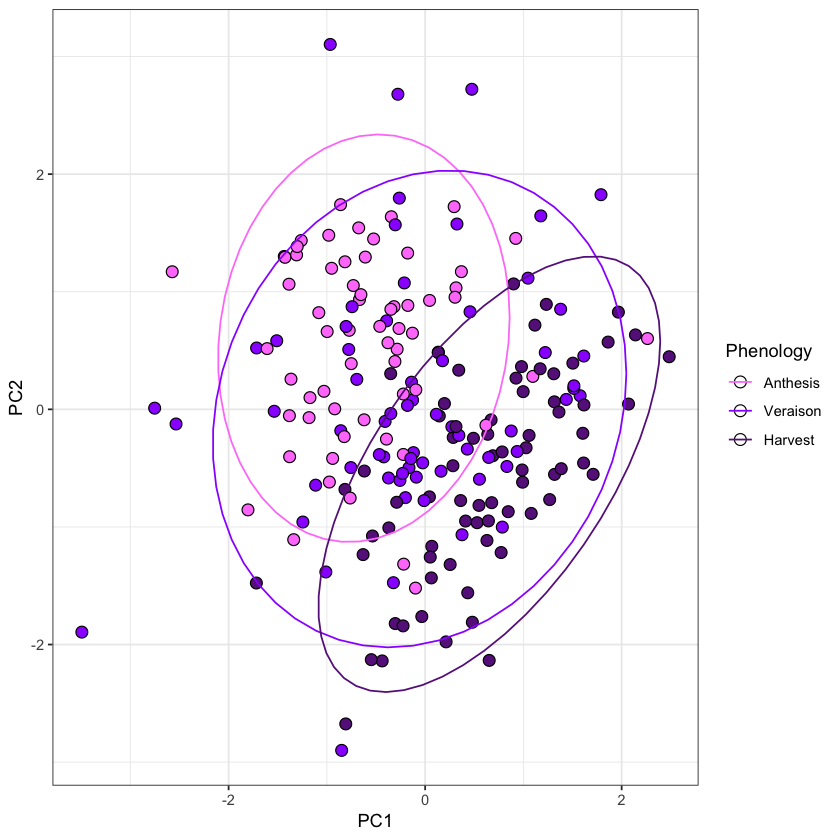

In [22]:
#as.matrix(GPA$percent)[1:34,]
spca.x <- as.data.frame(GPA$stdscores) %>% dplyr::select(PC1:PC34)
rownames(spca.x) <- test.labels$sampleName

## check
ggplot(spca.x, aes(x=PC1,y=PC2, fill=sdf$Phenology, shape=sdf$Phenology)) + 
  geom_point(size = 3) + 
  scale_shape_manual('Phenology', values=c(21, 21, 21)) + 
  scale_fill_manual('Phenology', values=c('orchid1', 'purple1', 'darkorchid4')) + 
  stat_ellipse(aes(color=sdf$Phenology)) + scale_color_manual('Phenology', values=c('orchid1', 'purple1', 'darkorchid4')) + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white"))) +
  theme_bw()

## Integration

This section is going to have a series of major challenges. ~First, while all metadata are using a controlled vocabulary, sample names are not. It will likely be easiest to use the RNAseq samples names, but that will require a some hunting.~ Once accomplished, I need to generate a matrix that has a single row for every sample at each time point and a single column for the top N PCs in each data type. Correlation matrices can be computed from that matrix. 

If we want to do any thing like compare phenological stages, we will need to drop the metabolomics data because I only have it for veraison and harvest. 

There is a lot of playing around in this section, but version presented in the manuscript extracts the top 4 PCs of each data modality. 

### How Many PCs to 80%? How Many PCs >5%?

In [31]:
sum(head(t(summary(ipca)[['importance']]), 10)[, 'Proportion of Variance']) # 8, 4
sum(head(t(summary(mpca)[['importance']]), 10)[, 'Proportion of Variance']) # 8, 4
sum(head(t(summary(gpca)[['importance']]), 10)[, 'Proportion of Variance']) # 8, 4

#summary(mpca) # 44, 3
#summary(gpca) # 19, 2
sum(as.matrix(GPA$percent)[1:10,]) # 7, 4

[1] 0.88899

[1] 0.55942

[1] 0.74756

[1] 87.91584

In [33]:
ipca.xc <- ipca.x %>% select(PC1:PC20)
colnames(ipca.xc) <- paste('iPC', 1:20, sep='')
ipca.xc$sampleName <- rownames(ipca.xc)

mpca.xc <- mpca.x %>% select(PC1:PC44)
colnames(mpca.xc) <- paste('mPC', 1:44, sep='')
mpca.xc$sampleName <- rownames(mpca.x)

gpca.xc <- gpca.x %>% select(PC1:PC20)
colnames(gpca.xc) <- paste('gPC', 1:20, sep='')
gpca.xc$sampleName <- rownames(gpca.x)

spca.xc <- spca.x %>% select(PC1:PC20)
colnames(spca.xc) <- paste('sPC', 1:20, sep='')
spca.xc$sampleName <- rownames(spca.x)

### Veraison and Harvest, Top 8 PCs Each

In [34]:
master.1 <- merge(ipca.xc, mpca.xc, on="sampleName")
master.2 <- merge(gpca.xc, spca.xc, on="sampleName")
master <- merge(master.1, master.2, on="sampleName")

dim(master)
head(master)

[1] 126 105

sampleName,iPC1,iPC2,iPC3,iPC4,iPC5,iPC6,iPC7,iPC8,iPC9,⋯,sPC11,sPC12,sPC13,sPC14,sPC15,sPC16,sPC17,sPC18,sPC19,sPC20
A1Y1_073_L,-10.7704261,-10.034476,4.2119354,-0.70404335,4.8760629,-2.41206550,0.51582383,-2.5940726,1.34658340,⋯,0.50898433,1.87484983,1.6451987,-0.6572064,0.74321656,-1.1704350,0.5591803,-0.17163480,0.6084566,0.8050281
A1Y1_076_L,1.8944858,-1.274944,-0.3220241,0.01407705,-0.7289965,-0.34714255,0.40870722,0.3062500,-0.11734300,⋯,0.54740047,1.20764316,0.2539803,1.2201898,2.08808833,1.6206929,1.7100875,-0.57000862,0.8822613,1.3858801
A1Y1_077_L,-4.9070836,-1.084068,-1.2678027,-1.27427445,0.4738595,-0.47728740,0.21866444,0.4541334,-0.96500742,⋯,-0.01900355,0.60023404,0.2254262,-0.7790951,0.42224181,0.8463695,-0.2393535,0.64579271,-1.0569092,1.7885493
A1Y1_078_L,0.7802516,-1.328334,0.4360597,-1.58884064,-0.1981245,0.09298163,0.26706233,-0.5995611,-0.60804961,⋯,0.67792542,0.74355724,0.2910983,-0.1972516,-0.06933552,-0.1875799,0.3914888,-1.52058929,0.3373857,1.4969646
A1Y1_079_L,1.4891164,-1.721963,-0.0104476,-1.95682152,-0.3209524,-0.01672097,-0.20178997,-0.9109546,0.25031833,⋯,-1.66174714,0.07346873,0.9080546,-0.3646497,-1.00978867,-0.0521552,2.4593628,-0.08880635,0.2779190,1.1126096
A1Y1_080_L,2.5333745,-1.790084,0.2037246,-0.93511293,-0.2565166,-0.14923514,0.02870704,-0.7741107,0.01492037,⋯,-0.14696264,-0.48277711,-0.2034714,0.3882335,-0.16958769,0.8555726,0.2906240,1.43571886,0.1976536,1.6161254


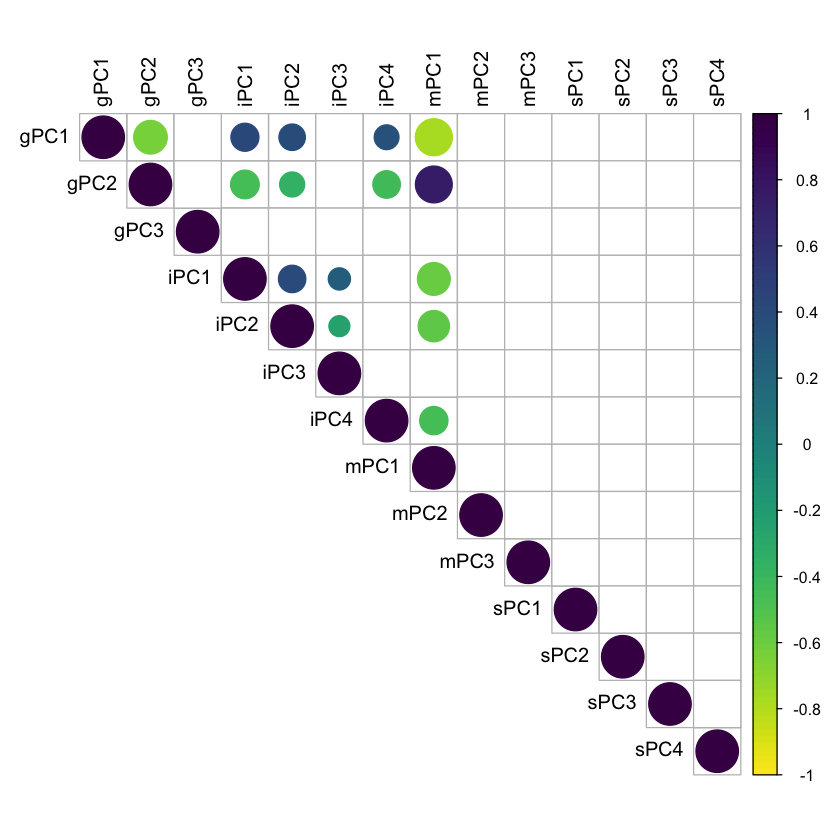

In [35]:
d <- master %>% select(iPC1:iPC4, mPC1:mPC3, gPC1:gPC3, sPC1:sPC4)

x <- cor(d)
res1 <- cor.mtest(d, conf.level = .95)
colnames(res1$p) <- colnames(x)
rownames(res1$p) <- rownames(x)

pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=14)
colnames(pmat.adj) <- colnames(x)
rownames(pmat.adj) <- rownames(x)

corrplot(x, order = "alphabet", type='upper', tl.col = "black", 
         col=rev(viridis(100)), p.mat = pmat.adj, sig.level = .05, insig='blank')


### Veraison and Harvest, Top 4 PCs Each

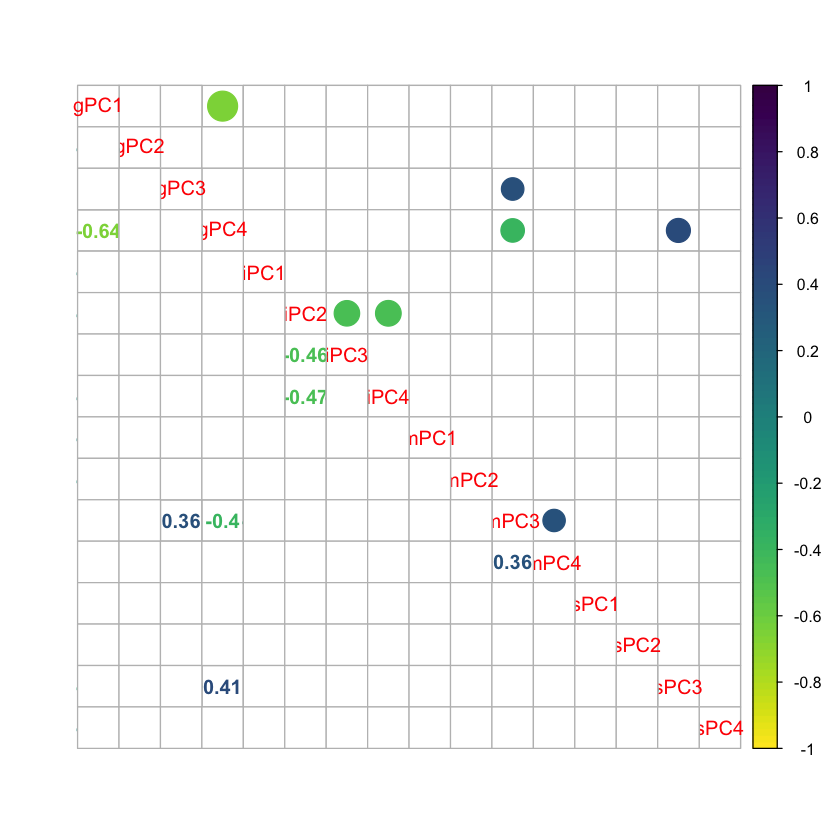

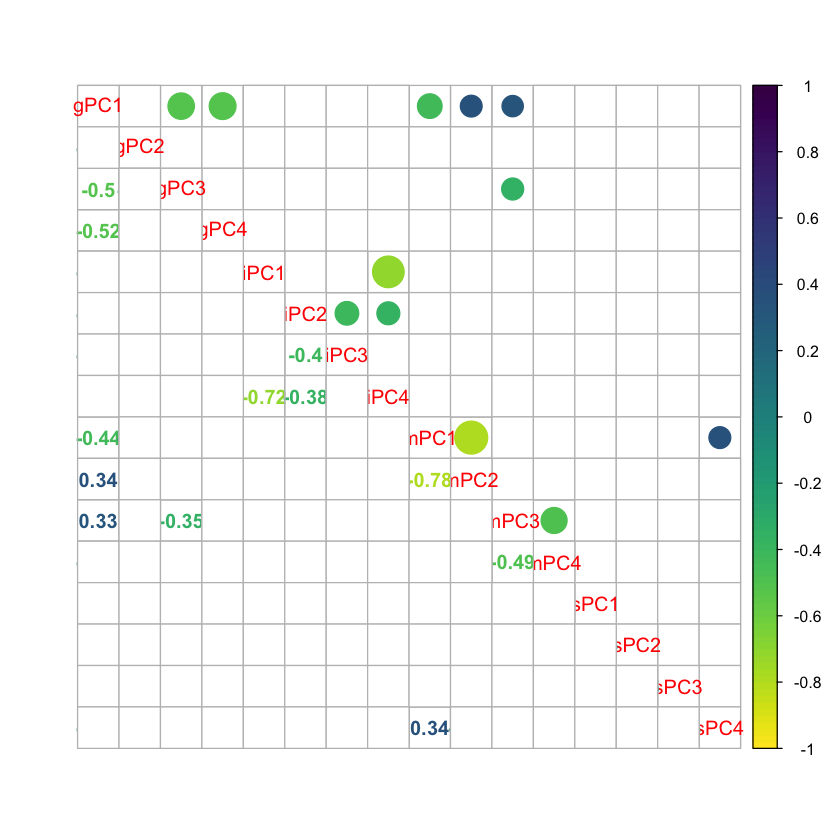

In [36]:
master.1 <- merge(ipca.xc, mpca.xc, on="sampleName")
master.2 <- merge(gpca.xc, spca.xc, on="sampleName")
master <- merge(master.1, master.2, on="sampleName")
master <- merge(master, master_meta, on="sampleName")

m.veraison <- master[master$Phenology.m == 'Veraison',] %>% select(iPC1:iPC4, mPC1:mPC4, gPC1:gPC4, sPC1:sPC4)
m.harvest <- master[master$Phenology.m == 'Harvest',] %>% select(iPC1:iPC4, mPC1:mPC4, gPC1:gPC4, sPC1:sPC4)

#pdf('2017_PCcorrplot_phenology_PCs_top4PCs.pdf', height=10, width=10, onefile=T)

x <- cor(m.veraison)
res1 <- cor.mtest(m.veraison, conf.level = .95)
colnames(res1$p) <- colnames(x)
rownames(res1$p) <- rownames(x)

pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=16)
colnames(pmat.adj) <- colnames(x)
rownames(pmat.adj) <- rownames(x)

corrplot.mixed(x, order = "alphabet", lower.col=rev(viridis(100)), upper.col=rev(viridis(100)),
               p.mat = pmat.adj, sig.level = .05, insig='blank')

x <- cor(m.harvest)
res1 <- cor.mtest(m.harvest, conf.level = .95)
colnames(res1$p) <- colnames(x)
rownames(res1$p) <- rownames(x)

pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=16)
colnames(pmat.adj) <- colnames(x)
rownames(pmat.adj) <- rownames(x)

corrplot.mixed(x, order = "alphabet", lower.col=rev(viridis(100)), upper.col=rev(viridis(100)),
               p.mat = pmat.adj, sig.level = .05, insig='blank')

#dev.off()

### By Phenology, No Metabolomics, Top 4 PCs from Each

,iPC1,iPC2,iPC3,iPC4,gPC1,gPC2,gPC3,gPC4,sPC1,sPC2,sPC3,sPC4
iPC1,0.000000000,0.007892815,0.88168154,0.08809511,3.775450e-01,8.816815e-01,0.8816815,0.7453207,0.8212156,0.8816815,0.8816815,0.7453207
iPC2,0.007892815,0.000000000,0.01217915,0.76930892,8.816815e-01,2.116020e-01,0.1219448,0.9629767,0.8750366,0.9113331,0.5505343,0.3534685
iPC3,0.881681537,0.012179149,0.00000000,0.91452825,6.585514e-01,2.362030e-01,0.7142984,0.8750366,0.7142984,0.8004949,0.2068753,0.5849332
iPC4,0.088095111,0.769308920,0.91452825,0.00000000,8.816815e-01,9.145282e-01,0.4484702,0.9145282,0.8816815,0.8254799,0.8750366,0.8816815
gPC1,0.377545044,0.881681537,0.65855138,0.88168154,0.000000e+00,1.685662e-16,0.8750366,0.8750366,0.8750366,0.8816815,0.7453207,0.8816815
gPC2,0.881681537,0.211601968,0.23620298,0.91452825,1.685662e-16,0.000000e+00,0.2146193,0.4484702,0.7854601,0.7453207,0.3775450,0.9272317
gPC3,0.881681537,0.121944796,0.71429839,0.44847018,8.750366e-01,2.146193e-01,0.0000000,0.6585514,0.8816815,0.9293114,0.8816815,0.9272317
gPC4,0.745320704,0.962976734,0.87503659,0.91452825,8.750366e-01,4.484702e-01,0.6585514,0.0000000,0.7854601,0.8816815,0.8816815,0.2068753
sPC1,0.821215633,0.875036591,0.71429839,0.88168154,8.750366e-01,7.854601e-01,0.8816815,0.7854601,0.0000000,0.5711719,0.8816815,0.5711719
sPC2,0.881681537,0.911333141,0.80049493,0.82547993,8.816815e-01,7.453207e-01,0.9293114,0.8816815,0.5711719,0.0000000,0.5849332,0.8816815


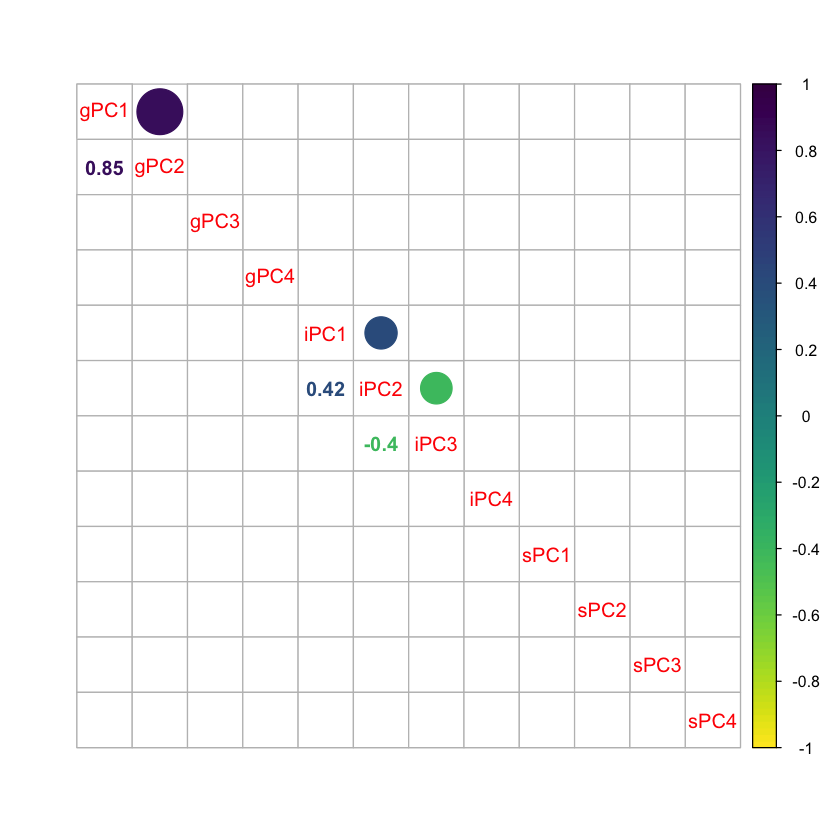

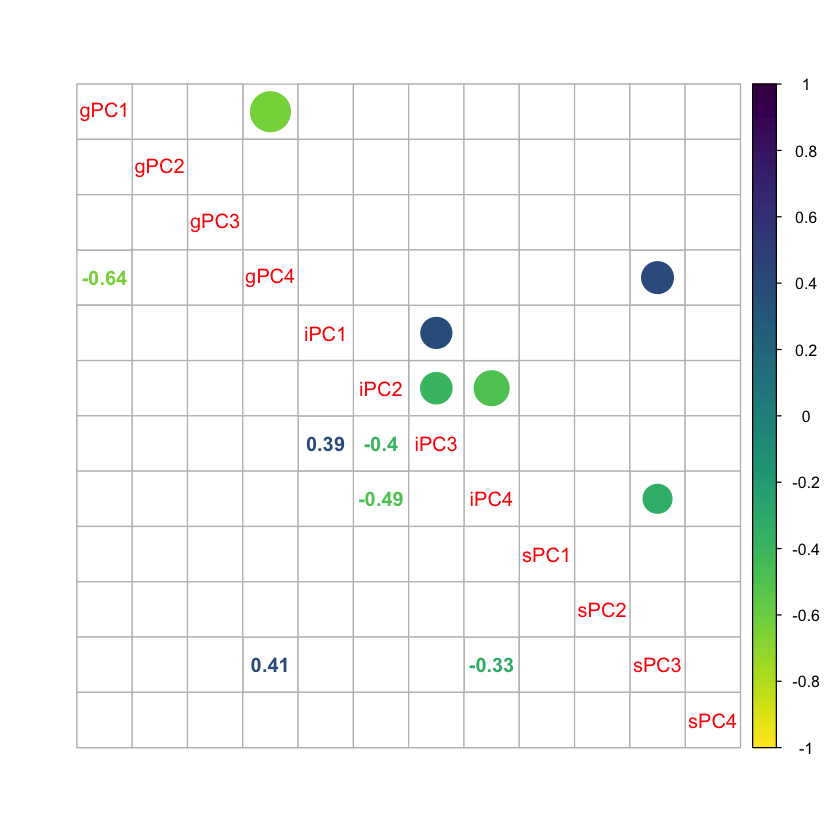

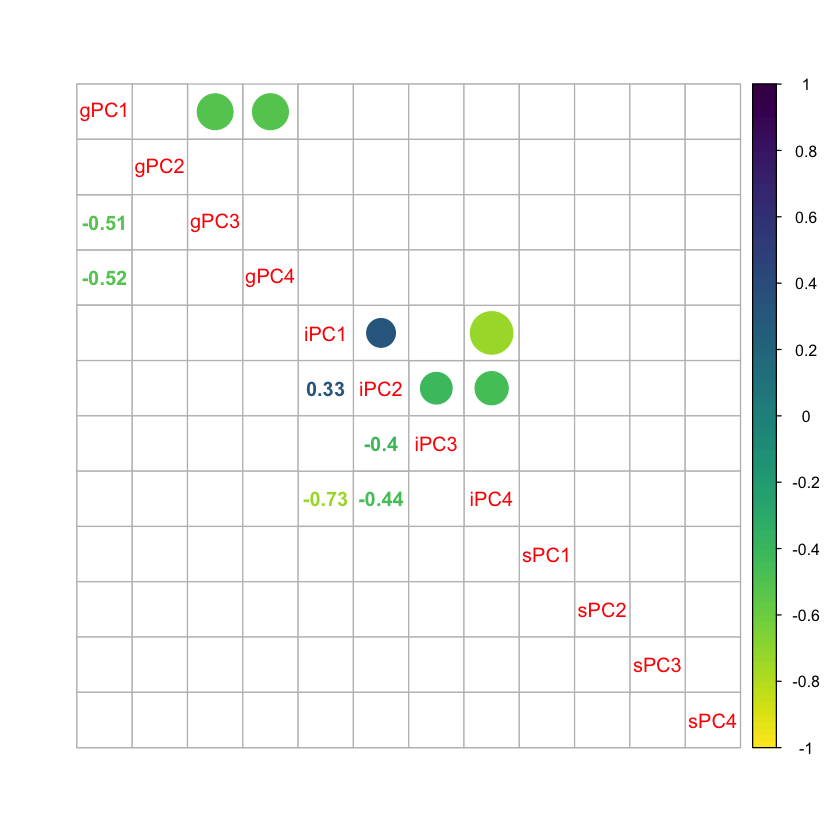

In [68]:
master <- merge(ipca.xc, gpca.xc, on="sampleName")
master <- merge(master, spca.xc, on="sampleName")
master <- merge(master, master_meta, on='sampleName')

m.anthesis <- master[master$Phenology.m == 'Anthesis',] %>% select(iPC1:iPC4, gPC1:gPC4, sPC1:sPC4)
m.veraison <- master[master$Phenology.m == 'Veraison',] %>% select(iPC1:iPC4, gPC1:gPC4, sPC1:sPC4)
m.harvest <- master[master$Phenology.m == 'Harvest',] %>% select(iPC1:iPC4, gPC1:gPC4, sPC1:sPC4)

#pdf('2017_PCcorrplot_phenology_noMetabolomics_PCs_top4PCs.pdf', height=10, width=10, onefile=T)

x <- cor(m.anthesis)
res1 <- cor.mtest(m.anthesis, conf.level = .95)
colnames(res1$p) <- colnames(x)
rownames(res1$p) <- rownames(x)

pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=12)
colnames(pmat.adj) <- colnames(x)
rownames(pmat.adj) <- rownames(x)

pmat.adj

corrplot.mixed(x, order = "alphabet", lower.col=rev(viridis(100)), upper.col=rev(viridis(100)),
               p.mat = pmat.adj, sig.level = .05, insig='blank')

x <- cor(m.veraison)
res1 <- cor.mtest(m.veraison, conf.level = .95)
colnames(res1$p) <- colnames(x)
rownames(res1$p) <- rownames(x)

pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=12)
colnames(pmat.adj) <- colnames(x)
rownames(pmat.adj) <- rownames(x)

corrplot.mixed(x, order = "alphabet", lower.col=rev(viridis(100)), upper.col=rev(viridis(100)),
               p.mat = pmat.adj, sig.level = .05, insig='blank')

x <- cor(m.harvest)
res1 <- cor.mtest(m.harvest, conf.level = .95)
colnames(res1$p) <- colnames(x)
rownames(res1$p) <- rownames(x)

pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=12)
colnames(pmat.adj) <- colnames(x)
rownames(pmat.adj) <- rownames(x)

corrplot.mixed(x, order = "alphabet", lower.col=rev(viridis(100)), upper.col=rev(viridis(100)),
               p.mat = pmat.adj, sig.level = .05, insig='blank')

#dev.off()

## Interesting Correlations

Here, I just pull out some of the strong or noteworthy significant correlations. Many of these make it into the supp figure. 

### First, lets test some correlations to see if they are robust
In this section, I create some function that compare correlations to a null distribution of shuffled data. If the "true correlations" are stronger than the summary of the null dist, I plot them. 

In [53]:
master.1 <- merge(ipca.xc, mpca.xc, on="sampleName")
master.2 <- merge(gpca.xc, spca.xc, on="sampleName")
master <- merge(master.1, master.2, on="sampleName")
master <- merge(master, master_meta, on="sampleName")

m.veraison <- master[master$Phenology.m == 'Veraison',] %>% select(iPC1:iPC10, mPC1:mPC10, gPC1:gPC10, sPC1:sPC10)
m.harvest <- master[master$Phenology.m == 'Harvest',] %>% select(iPC1:iPC10, mPC1:mPC10, gPC1:gPC10, sPC1:sPC10)

In [54]:
nullComparison <- function(v1, v2){
    true_correlation <- cor(v1, v2)
    null_dist <- list(true_cor=true_correlation, null_dist=c())
    for (i in 1:10000){
        v2_shuf <- sample(v2)
        null_dist$null_dist <- c(null_dist$null_dist, cor(v1, v2_shuf))
    }
    df <- data.frame(true_cor = rep(null_dist$true_cor, length(null_dist$null_dist)),
                    null_dist = null_dist$null_dist)
    return(df)
}

computeProp <- function(df){
    v <- abs(df$null_dist)
    true_cor <- abs(df$true_cor[1])
    prop_higher <- length(v[v >= true_cor]) / length(v)
    return(prop_higher)
}

plotCorDist <- function(df){
    p <- ggplot(df, aes(x=null_dist)) + 
      geom_density(lwd=2, color='grey35') + 
      geom_rug(color='grey35') + 
      geom_vline(xintercept=df$true_cor[1], color='salmon1', lwd=2) + 
      geom_vline(xintercept=-df$true_cor[1], color='salmon1', lwd=2, lty=2) + 
      annotate('text', label=paste("Prop. > 'True':",  computeProp(df)), x=0, y=0.1) + 
      theme_bw()
  return(p)
}

### Now let's establish a bootstrapping test, just in case

In [55]:
bootstrapCor <- function(v1, v2){
    df <- data.frame(v1=v1, v2=v2)
    rs <- c()
    N <- ceiling(length(v1) * 0.9)
    for (i in 1:10000){
        df_sub <- df[sample(1:length(v1), N),]
        rs <- c(rs, cor(df_sub$v1, df_sub$v2))
    }
    res <- list(mean=mean(rs), CI.low.sd=(mean(rs)-2*sd(rs)), CI.high.sd=(mean(rs)+2*sd(rs)),
                CI.low.q=quantile(rs, 0.025), CI.high.q=quantile(rs, 0.975))
    return(res)
}

### Including Metabolomics

$mean
[1] -0.7806669

$CI.low.sd
[1] -0.8055409

$CI.high.sd
[1] -0.7557929

$CI.low.q
      2.5% 
-0.8084786 

$CI.high.q
    97.5% 
-0.759872

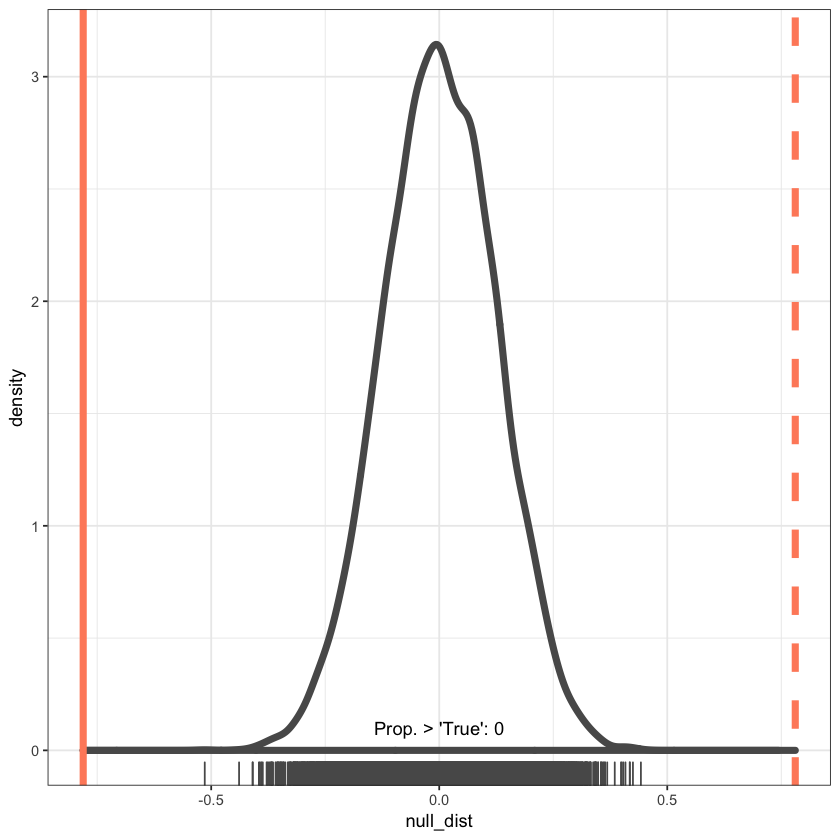

In [56]:
## this is just presented in the MS because it is stong
t1.harvest <- nullComparison(m.harvest$mPC1, m.harvest$mPC2)
p2 <- plotCorDist(t1.harvest)
p2

bootstrapCor(m.harvest$mPC1, m.harvest$mPC2)

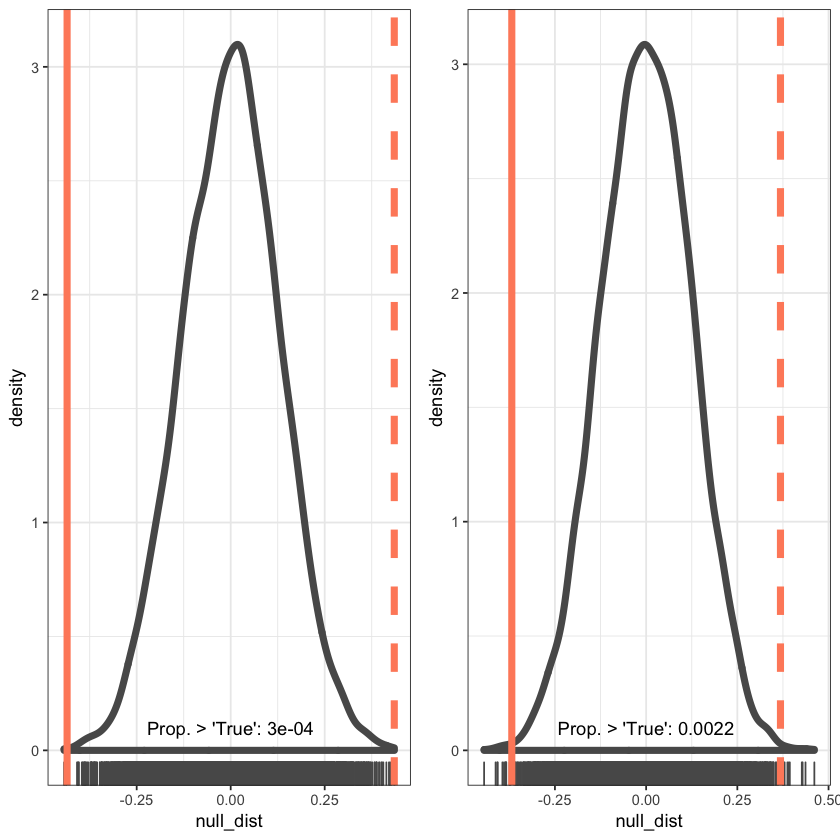

In [57]:
t1.veraison <- nullComparison(m.veraison$mPC3, m.veraison$gPC6)
t1.harvest <- nullComparison(m.harvest$mPC3, m.harvest$gPC6)

p1 <- plotCorDist(t1.veraison)
p2 <- plotCorDist(t1.harvest)

ggpubr::ggarrange(p1, p2, ncol=2)

In [80]:
bootstrapCor(m.veraison$mPC3, m.veraison$gPC6)
bootstrapCor(m.harvest$mPC3, m.harvest$gPC6)

$mean
[1] -0.435582

$CI.low.sd
[1] -0.5037233

$CI.high.sd
[1] -0.3674407

$CI.low.q
      2.5% 
-0.5041385 

$CI.high.q
     97.5% 
-0.3711186

$mean
[1] -0.3676979

$CI.low.sd
[1] -0.4463669

$CI.high.sd
[1] -0.2890289

$CI.low.q
      2.5% 
-0.4472117 

$CI.high.q
     97.5% 
-0.2844257

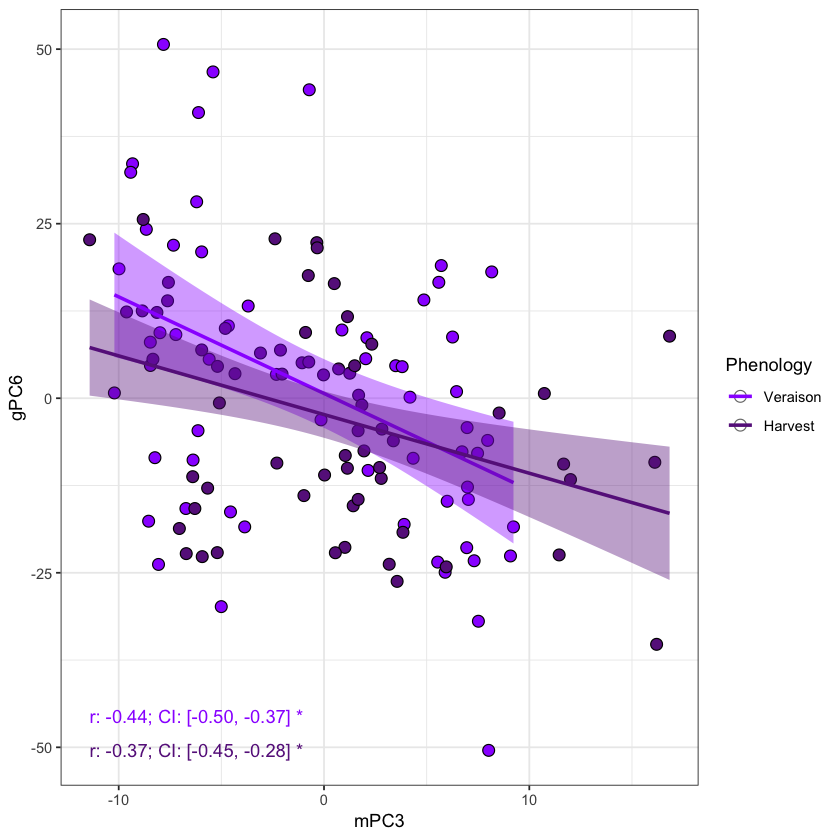

In [59]:
cpFig1c <- ggplot(master, aes(x=mPC3, y=gPC6, fill=Phenology.m, shape=Phenology.m)) + 
  geom_point(size=3) + 
  scale_fill_manual("Phenology", values=c('purple1', 'darkorchid4')) + 
  scale_shape_manual("Phenology",values=c(21, 21)) + 
  geom_smooth(aes(color=Phenology.m), method=lm) + 
  scale_color_manual("Phenology",values=c('purple1', 'darkorchid4')) + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white"))) +
  annotate('text', label="r: -0.44; CI: [-0.50, -0.37] *", color='purple1', 
           x=min(master$mPC3), y=min(master$gPC6)+5, hjust=0) + 
  annotate('text', label="r: -0.37; CI: [-0.45, -0.28] *", color='darkorchid4', 
           x=min(master$mPC3), y=min(master$gPC6), hjust=0) + 
  theme_bw() 

cpFig1c

$mean
[1] 0.578619

$CI.low.sd
[1] 0.5239081

$CI.high.sd
[1] 0.63333

$CI.low.q
     2.5% 
0.5306029 

$CI.high.q
    97.5% 
0.6363306

$mean
[1] -0.6582206

$CI.low.sd
[1] -0.7251881

$CI.high.sd
[1] -0.5912531

$CI.low.q
      2.5% 
-0.7493156 

$CI.high.q
     97.5% 
-0.6034048

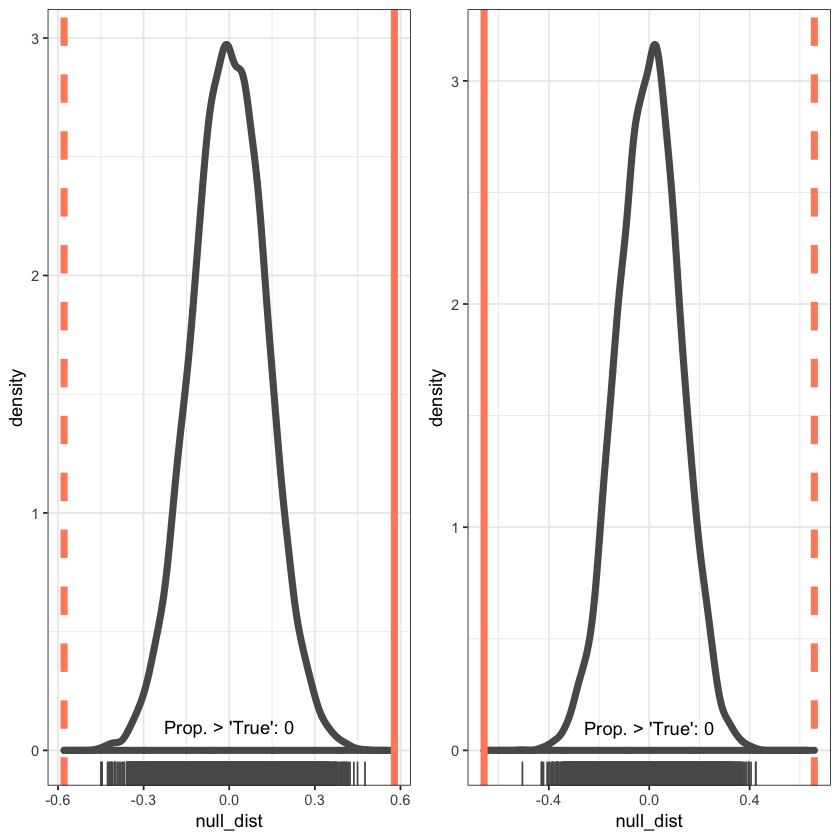

In [82]:
t1.veraison <- nullComparison(m.veraison$mPC3, m.veraison$mPC6)
t1.harvest <- nullComparison(m.harvest$mPC3, m.harvest$mPC6)
p1 <- plotCorDist(t1.veraison)
p2 <- plotCorDist(t1.harvest)
ggpubr::ggarrange(p1, p2, ncol=2)

bootstrapCor(m.veraison$mPC3, m.veraison$mPC6)
bootstrapCor(m.harvest$mPC3, m.harvest$mPC6)

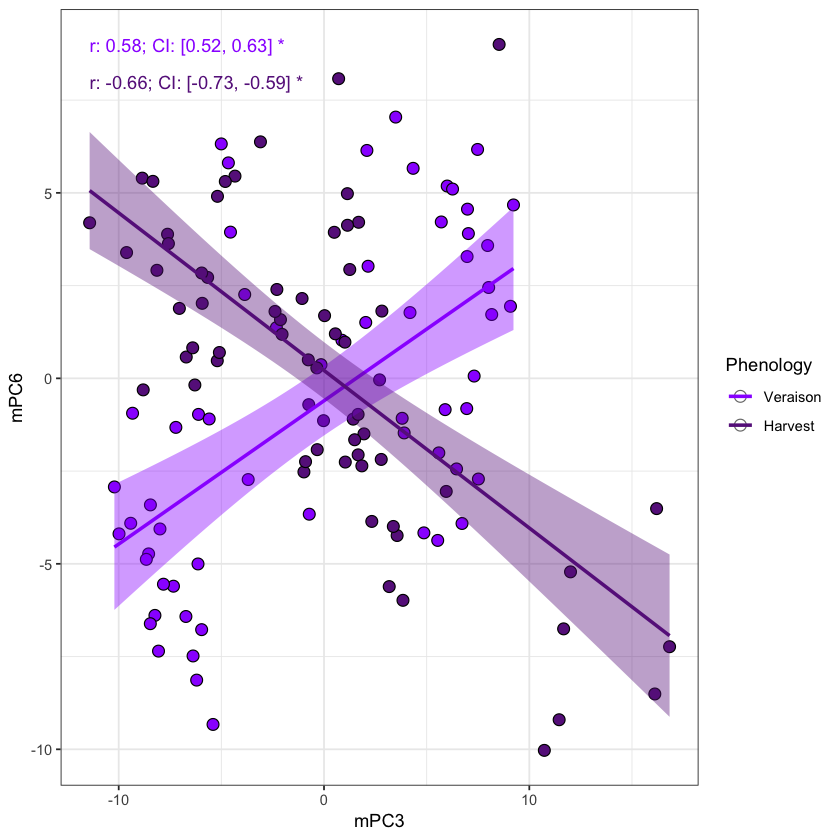

In [61]:
cpFig1d <- ggplot(master, aes(x=mPC3, y=mPC6, fill=Phenology.m, shape=Phenology.m)) + 
  geom_point(size=3) + 
  scale_fill_manual("Phenology", values=c('purple1', 'darkorchid4')) + 
  scale_shape_manual("Phenology",values=c(21, 21)) + 
  geom_smooth(aes(color=Phenology.m), method=lm) + 
  scale_color_manual("Phenology",values=c('purple1', 'darkorchid4')) + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white"))) +
  annotate('text', label="r: 0.58; CI: [0.52, 0.63] *", color='purple1', 
           x=min(master$mPC3), y=max(master$mPC6), hjust=0) + 
  annotate('text', label="r: -0.66; CI: [-0.73, -0.59] *", color='darkorchid4', 
           x=min(master$mPC3), y=max(master$mPC6)-1, hjust=0) + 
  theme_bw() 

cpFig1d

### Excluding Metabolomics

In [62]:
master <- merge(ipca.xc, gpca.xc, on="sampleName")
master <- merge(master, spca.xc, on="sampleName")
master <- merge(master, master_meta, on='sampleName')

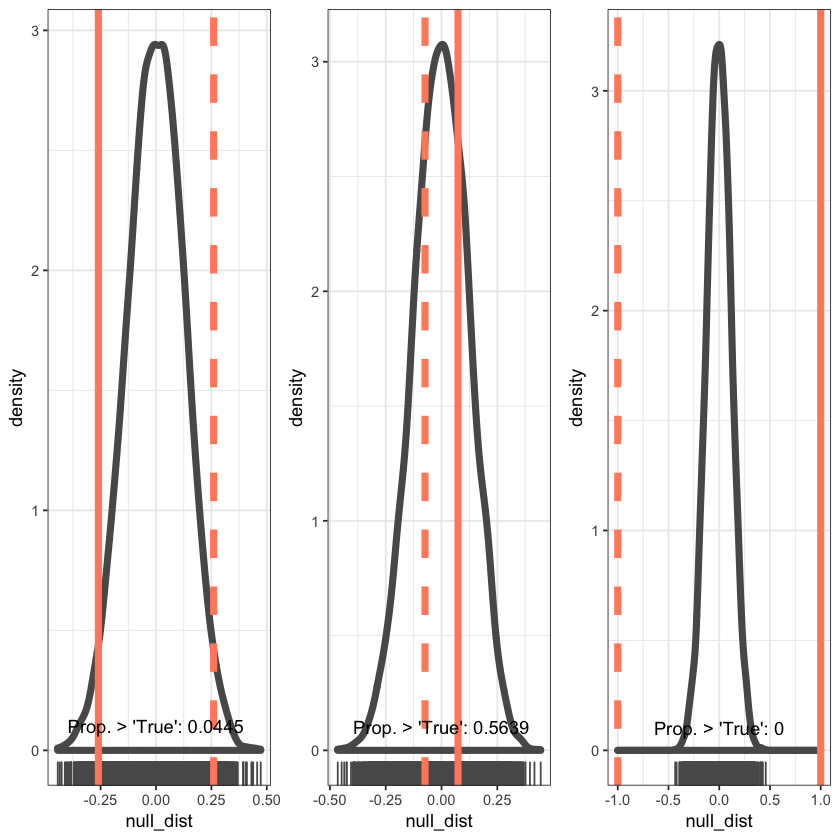

In [63]:
a <- master %>% filter(Phenology.m == 'Anthesis')
v <- master %>% filter(Phenology.m == 'Veraison')
h <- master %>% filter(Phenology.m == 'Harvest')

t1.anthesis <- nullComparison(a$gPC2, a$gPC3)
t1.veraison <- nullComparison(v$gPC2, v$gPC3)
t1.harvest <- nullComparison(h$gPC3, h$gPC3)

p1 <- plotCorDist(t1.anthesis)
p2 <- plotCorDist(t1.veraison)
p3 <- plotCorDist(t1.harvest)

ggpubr::ggarrange(p1, p2, p3, ncol=3)

In [45]:
bootstrapCor(a$gPC1, a$gPC2)
bootstrapCor(v$gPC1, v$gPC2)
bootstrapCor(h$gPC1, h$gPC2)

$mean
[1] 0.846212

$CI.low.sd
[1] 0.819101

$CI.high.sd
[1] 0.8733231

$CI.low.q
     2.5% 
0.8125209 

$CI.high.q
    97.5% 
0.8691401

$mean
[1] -0.04997646

$CI.low.sd
[1] -0.1514083

$CI.high.sd
[1] 0.05145535

$CI.low.q
      2.5% 
-0.1405675 

$CI.high.q
     97.5% 
0.06082647

$mean
[1] -0.1751175

$CI.low.sd
[1] -0.2429415

$CI.high.sd
[1] -0.1072935

$CI.low.q
      2.5% 
-0.2296017 

$CI.high.q
      97.5% 
-0.09755973

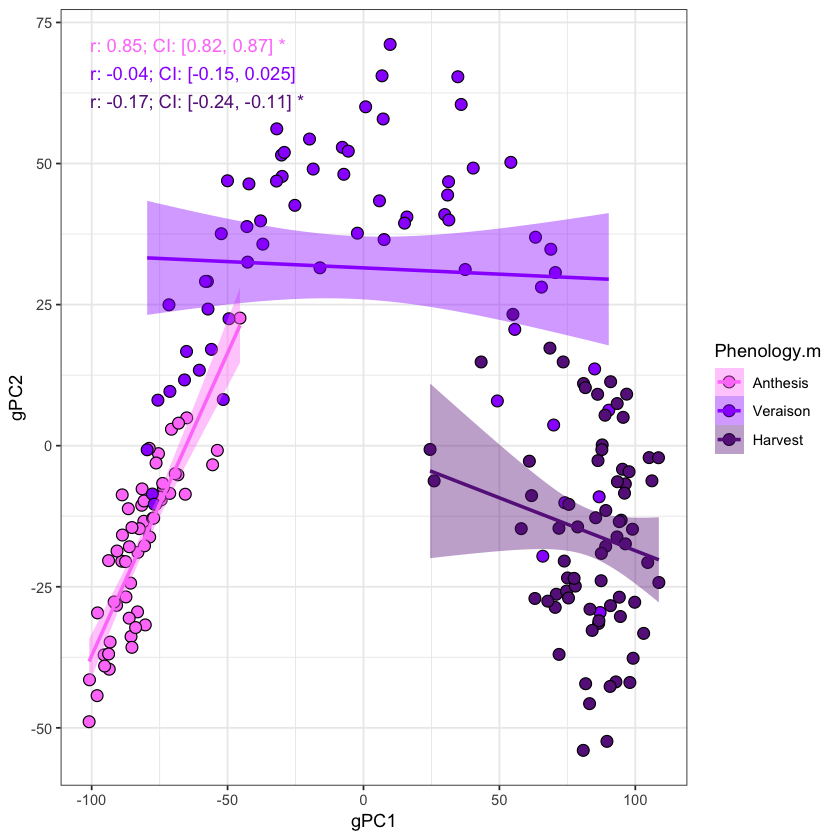

In [64]:
cpFig1a <- ggplot(master, aes(x=gPC1, gPC2, fill=Phenology.m, shape=Phenology.m)) + 
  geom_point(size=3) + 
  scale_fill_manual(values=c('orchid1', 'purple1', 'darkorchid4')) + 
  scale_shape_manual(values=c(21, 21, 21)) + 
  geom_smooth(aes(color=Phenology.m), method=lm) + 
  scale_color_manual(values=c('orchid1', 'purple1', 'darkorchid4')) + 
  #guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white"))) +
  annotate('text', label="r: 0.85; CI: [0.82, 0.87] *", color='orchid1', 
           x=min(master$gPC1)+0.5, y=max(master$gPC2), hjust=0) + 
  annotate('text', label="r: -0.04; CI: [-0.15, 0.025]", color='purple1', 
           x=min(master$gPC1)+0.5, y=max(master$gPC2)-5, hjust=0) + 
  annotate('text', label="r: -0.17; CI: [-0.24, -0.11] *", color='darkorchid4', 
           x=min(master$gPC1)+0.5, y=max(master$gPC2)-10, hjust=0) + 


  theme_bw() 
cpFig1a

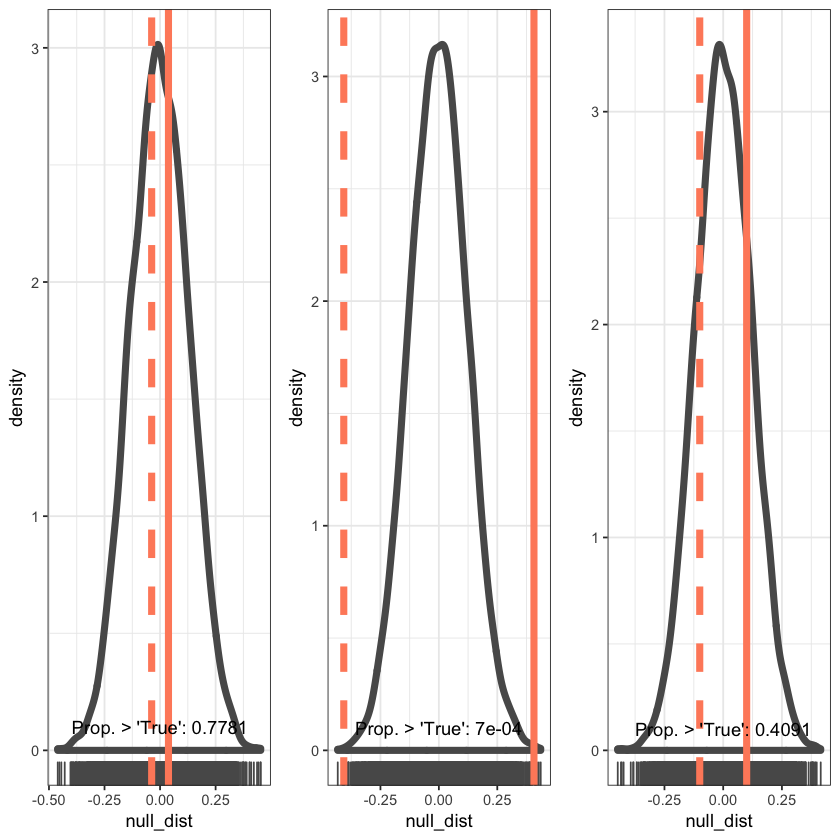

In [105]:
t1.anthesis <- nullComparison(a$gPC4, a$sPC3)
t1.veraison <- nullComparison(v$gPC4, v$sPC3)
t1.harvest <- nullComparison(h$gPC4, h$sPC3)

p1 <- plotCorDist(t1.anthesis)
p2 <- plotCorDist(t1.veraison)
p3 <- plotCorDist(t1.harvest)

ggpubr::ggarrange(p1, p2, p3, ncol=3)

In [106]:
bootstrapCor(a$gPC4, a$sPC3)
bootstrapCor(v$gPC4, v$sPC3)
bootstrapCor(h$gPC4, h$sPC3)

$mean
[1] 0.03828914

$CI.low.sd
[1] -0.05895024

$CI.high.sd
[1] 0.1355285

$CI.low.q
       2.5% 
-0.06477232 

$CI.high.q
    97.5% 
0.1335469

$mean
[1] 0.4068897

$CI.low.sd
[1] 0.3401964

$CI.high.sd
[1] 0.473583

$CI.low.q
     2.5% 
0.3403593 

$CI.high.q
    97.5% 
0.4781767

$mean
[1] 0.09967151

$CI.low.sd
[1] 0.01984721

$CI.high.sd
[1] 0.1794958

$CI.low.q
      2.5% 
0.02556092 

$CI.high.q
   97.5% 
0.183282

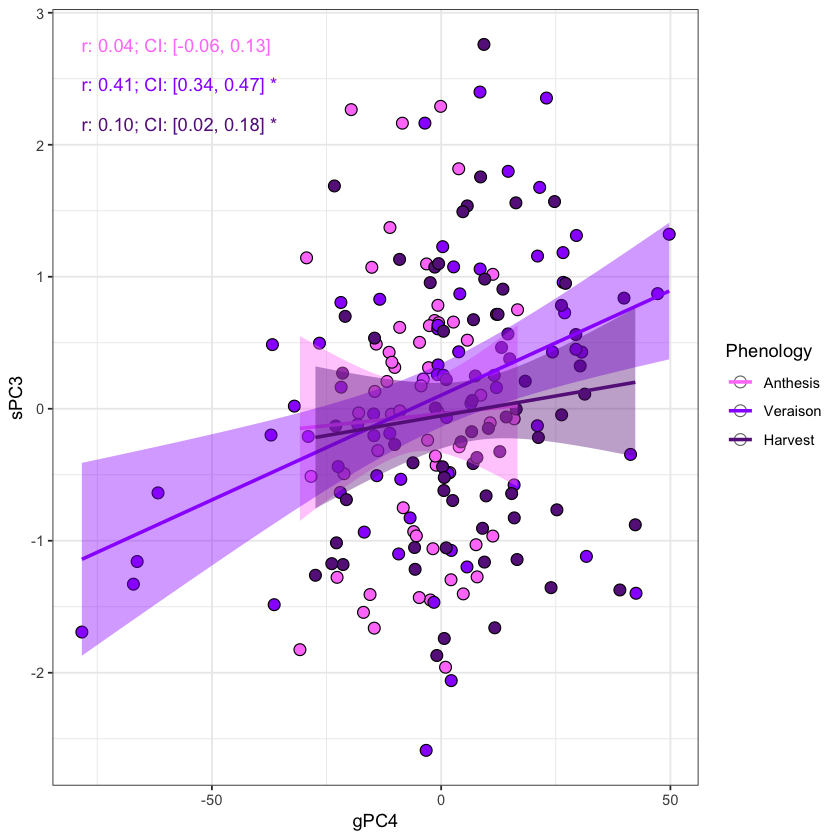

In [65]:
cpFig1b <- ggplot(master, aes(x=gPC4, y=sPC3, fill=Phenology.m, shape=Phenology.m)) + 
  geom_point(size=3) + 
  scale_fill_manual("Phenology", values=c('orchid1', 'purple1', 'darkorchid4')) + 
  scale_shape_manual("Phenology", values=c(21, 21, 21)) + 
  geom_smooth(aes(color=Phenology.m), method=lm) + 
  scale_color_manual("Phenology", values=c('orchid1', 'purple1', 'darkorchid4')) + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white"))) +
  annotate('text', label="r: 0.04; CI: [-0.06, 0.13]", color='orchid1', 
           x=min(master$gPC4), y=max(master$sPC3), hjust=0) + 
  annotate('text', label="r: 0.41; CI: [0.34, 0.47] *", color='purple1', 
           x=min(master$gPC4), y=max(master$sPC3)-0.3, hjust=0) + 
  annotate('text', label="r: 0.10; CI: [0.02, 0.18] *", color='darkorchid4', 
           x=min(master$gPC4), y=max(master$sPC3)-0.6, hjust=0) + 
  theme_bw() 
cpFig1b

In [66]:
pdf("2017_corrplot_examples.pdf", height=10, width=10)
  ggpubr::ggarrange(cpFig1a, cpFig1b, cpFig1c, cpFig1d, common.legend=T, ncol=2, nrow=2, legend='right', labels=c('A', 'B', 'C', 'D'))
dev.off()

pdf 
  2

## Networks?

Just noodling. 

In [178]:
pmat.adj

,iPC1,iPC2,iPC3,iPC4,gPC1,gPC2,gPC3,gPC4,sPC1,sPC2,sPC3,sPC4
iPC1,0.0000000000,0.0000462104,9.088728e-01,2.605016e-01,2.917888e-01,9.088728e-01,0.9088728,0.8140335,0.7931200,0.9088728,0.9088728,0.7613712
iPC2,0.0000462104,0.0000000000,7.148268e-01,9.088728e-01,9.132039e-01,2.955590e-01,0.1536388,0.9903313,0.9088728,0.9293114,0.6337220,0.6365997
iPC3,0.9088727868,0.7148267685,0.000000e+00,1.073629e-06,9.293114e-01,9.293114e-01,0.5106863,0.2439890,0.9088728,0.5106863,0.4341422,0.9132039
iPC4,0.2605016333,0.9088727868,1.073629e-06,0.000000e+00,9.002971e-01,8.140335e-01,0.5434250,0.5106863,0.9002971,0.9293114,0.9132039,0.9088728
gPC1,0.2917887840,0.9132039282,9.293114e-01,9.002971e-01,0.000000e+00,1.685662e-16,0.9002971,0.9088728,0.9002971,0.9088728,0.7613712,0.9088728
gPC2,0.9088727868,0.2955589756,9.293114e-01,8.140335e-01,1.685662e-16,0.000000e+00,0.2476376,0.4925709,0.8066887,0.7613712,0.4003139,0.9293114
gPC3,0.9088727868,0.1536388264,5.106863e-01,5.434250e-01,9.002971e-01,2.476376e-01,0.0000000,0.6365997,0.9132039,0.9293114,0.9132039,0.9293114
gPC4,0.8140334934,0.9903313091,2.439890e-01,5.106863e-01,9.088728e-01,4.925709e-01,0.6365997,0.0000000,0.8066887,0.9088728,0.9132039,0.2439890
sPC1,0.7931200200,0.9088727868,9.088728e-01,9.002971e-01,9.002971e-01,8.066887e-01,0.9132039,0.8066887,0.0000000,0.5483250,0.9088728,0.5483250
sPC2,0.9088727868,0.9293114077,5.106863e-01,9.293114e-01,9.088728e-01,7.613712e-01,0.9293114,0.9088728,0.5483250,0.0000000,0.5645511,0.9132039


In [73]:
master <- merge(ipca.xc, gpca.xc, on="sampleName")
master <- merge(master, spca.xc, on="sampleName")
master <- merge(master, master_meta, on='sampleName')

m.anthesis <- master[master$Phenology.m == 'Anthesis',] %>% select(iPC1:iPC10, gPC1:gPC10, sPC1:sPC10)

pdf('2017_PCcorrplot_networks_Anthesis.pdf', height=10, width=10)

x <- cor(m.anthesis)
res1 <- cor.mtest(m.anthesis, conf.level = .95)
colnames(res1$p) <- colnames(x)
rownames(res1$p) <- rownames(x)

pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=30)
colnames(pmat.adj) <- colnames(x)
rownames(pmat.adj) <- rownames(x)

screen_mat <- pmat.adj
screen_mat[screen_mat > 0.05] <- 1
x[screen_mat == 1] <- 0

g_raw <- graph_from_adjacency_matrix(x, mode='upper', weighted=T, diag=F)
g <- graph_from_adjacency_matrix(abs(x)^2, mode='upper', weighted=T, diag=F)
E(g)$color[E(g_raw)$weight > 0] <- 'skyblue1'
E(g)$color[E(g_raw)$weight < 0] <- 'salmon1'
plot(g, layout=layout.auto, edge.width=abs(E(g)$weight)*16, vertex.color='white')

dev.off()

pdf 
  2

In [74]:
master.1 <- merge(ipca.xc, mpca.xc, on="sampleName")
master.2 <- merge(gpca.xc, spca.xc, on="sampleName")
master <- merge(master.1, master.2, on="sampleName")
master <- merge(master, master_meta, on="sampleName")

m.veraison <- master[master$Phenology.m == 'Veraison',] %>% select(iPC1:iPC10, mPC1:mPC10, gPC1:gPC10, sPC1:sPC10)
m.harvest <- master[master$Phenology.m == 'Harvest',] %>% select(iPC1:iPC10, mPC1:mPC10, gPC1:gPC10, sPC1:sPC10)

pdf('2017_PCcorrplot_networks_VeraisonHarvest.pdf', height=10, width=10, onefile=T)

#veraison
x <- cor(m.veraison)
res1 <- cor.mtest(m.veraison, conf.level = .95)
colnames(res1$p) <- colnames(x)
rownames(res1$p) <- rownames(x)

pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=40)
colnames(pmat.adj) <- colnames(x)
rownames(pmat.adj) <- rownames(x)

screen_mat <- pmat.adj
screen_mat[screen_mat > 0.05] <- 0
x[screen_mat == 0] <- 0

g_raw <- graph_from_adjacency_matrix(x, mode='upper', weighted=T, diag=F)
g <- graph_from_adjacency_matrix(abs(x)^2, mode='upper', weighted=T, diag=F)
E(g)$color[E(g_raw)$weight > 0] <- 'skyblue1'
E(g)$color[E(g_raw)$weight < 0] <- 'salmon1'
plot(g, layout=layout.auto, edge.width=abs(E(g)$weight)*16, vertex.color='white')

#harvest
x <- cor(m.harvest)
res1 <- cor.mtest(m.harvest, conf.level = .95)
colnames(res1$p) <- colnames(x)
rownames(res1$p) <- rownames(x)

pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=40)
colnames(pmat.adj) <- colnames(x)
rownames(pmat.adj) <- rownames(x)

screen_mat <- pmat.adj
screen_mat[screen_mat > 0.05] <- 0
x[screen_mat == 0] <- 0

g_raw <- graph_from_adjacency_matrix(x, mode='upper', weighted=T, diag=F)
g <- graph_from_adjacency_matrix(abs(x)^2, mode='upper', weighted=T, diag=F)
E(g)$color[E(g_raw)$weight > 0] <- 'skyblue1'
E(g)$color[E(g_raw)$weight < 0] <- 'salmon1'
plot(g, layout=layout.auto, edge.width=abs(E(g)$weight)*16, vertex.color='white')

dev.off()

pdf 
  2